## Importing Libraries

In [1]:
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution

In [2]:
disable_eager_execution()

## Loading data from MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## Preprocessing data

In [4]:
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255

img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

## Visualizing data

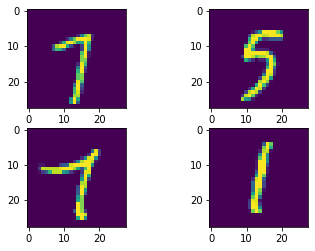

In [5]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:, :, 0])

plt.subplot(222)
plt.imshow(x_train[420][:, :, 0])

plt.subplot(223)
plt.imshow(x_train[4200][:, :, 0])

plt.subplot(224)
plt.imshow(x_train[42000][:, :, 0])
plt.show()

## Building the Model

### Encoder

In [6]:
latent_dim = 2

input_img = Input(shape=input_shape, name="encoder_input")
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

### Flatten

In [7]:
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)

In [8]:
def sampleZ(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

In [9]:
z = Lambda(sampleZ, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [10]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

In [11]:
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

### Decoder

In [12]:
decoder_input = Input(shape=(latent_dim, ), name= "decoder_input")
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides = (2,2))(x)
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

In [13]:
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [14]:
z_decoded = decoder(z)

## Defining Custom Loss

In [15]:
class CustomLayer(tensorflow.keras.layers.Layer):
    
    def vaeLoss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        #Reconstruction Loss
        recon_loss = tensorflow.keras.metrics.binary_crossentropy(x, z_decoded)
        
        #KL Divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=1)
        
        return K.mean(recon_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vaeLoss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [16]:
y = CustomLayer()([input_img, z_decoded])
vae = Model(input_img, y, name='vae')

In [17]:
vae.compile(optimizer='adam', loss=None, experimental_run_tf_function=False)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
________________________________________________________________________________________________

## Training the Model

In [18]:
vae.fit(x_train, None, epochs=50, batch_size=32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50


2022-10-23 06:16:38.671986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 06:16:38.672896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 06:16:38.843755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 06:16:38.844643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 06:16:38.845458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

47936/48000 [============================>.] - ETA: 0s - loss: 0.2264

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 23s 484us/sample - loss: 0.2264 - val_loss: 0.2053
Epoch 2/50
48000/48000 [==============================] - 9s 185us/sample - loss: 0.2009 - val_loss: 0.1972
Epoch 3/50
48000/48000 [==============================] - 9s 187us/sample - loss: 0.1953 - val_loss: 0.1932
Epoch 4/50
48000/48000 [==============================] - 9s 187us/sample - loss: 0.1921 - val_loss: 0.1917
Epoch 5/50
48000/48000 [==============================] - 9s 194us/sample - loss: 0.1898 - val_loss: 0.1893
Epoch 6/50
48000/48000 [==============================] - 9s 185us/sample - loss: 0.1883 - val_loss: 0.1877
Epoch 7/50
48000/48000 [==============================] - 9s 181us/sample - loss: 0.1870 - val_loss: 0.1870
Epoch 8/50
48000/48000 [==============================] - 9s 193us/sample - loss: 0.1859 - val_loss: 0.1862
Epoch 9/50
48000/48000 [==============================] - 9s 187us/sample - loss: 0.1851 - val_loss: 0.1869
Epoch 10/50
48000/48000 [=============

## Visualizing data

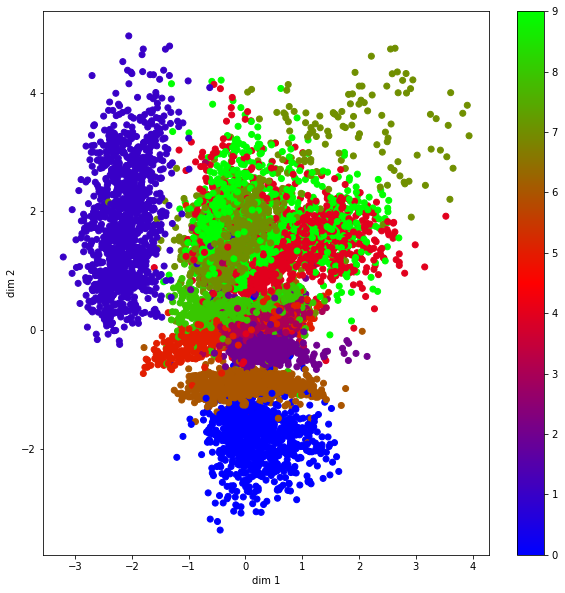

In [19]:
mu, _, _ = encoder.predict(x_test)
plt.figure(figsize = (10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

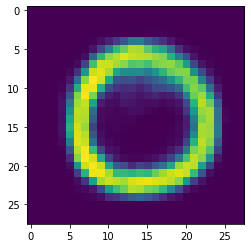

In [20]:
sample_vector = np.array([[1, -2]])
decoded_exp = decoder.predict(sample_vector)
exp_reshaped = decoded_exp.reshape(img_width, img_height)
plt.imshow(exp_reshaped)

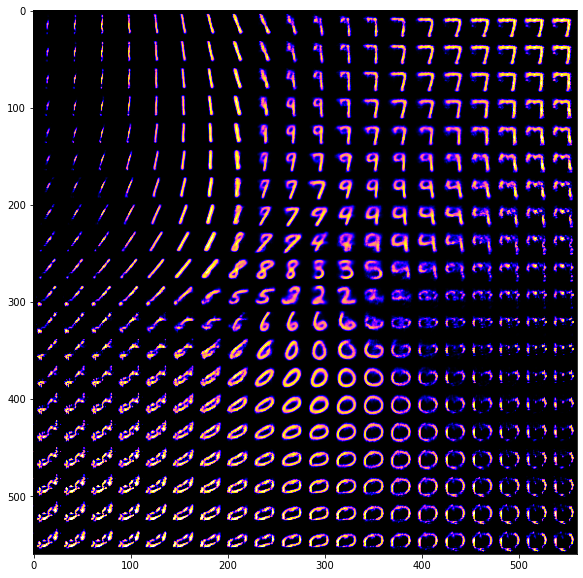

In [21]:
n = 20
fig = np.zeros((img_width *n, img_height * n, num_channels))
g_x = np.linspace(-5, 5, n)
g_y = np.linspace(-5, 5, n)[::-1]

for i, yi in enumerate(g_y):
    for j, xi in enumerate(g_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        fig[i * img_width: (i + 1) * img_width,
            j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
fig_shape = np.shape(fig)
fig = fig.reshape((fig_shape[0], fig_shape[1]))
plt.imshow(fig, cmap='gnuplot2')
plt.show()